## 1. Problem Definiton ##

Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2. Data ##

Our dataset is taken from here: https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci

Raw: https://github.com/ukvar/Machine-Learning-Zoomcamp-Homeworks/blob/main/Midterm-Project/heart.csv

## 3. Evaluation ##

Although Data set is very small, we will try to get best performance on different models.

## 4. Features ##

This is where you'll get different information about each of the features in your data.

Data dictionary

- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
- Value 0: typical angina
    - Value 1: atypical angina
    - Value 2: non-anginal pain
    - Value 3: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 0: upsloping
    - Value 1: flat
    - Value 2: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
- condition: 0 = no disease, 1 = disease

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bentoml

%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import scale,StandardScaler
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:/Users/uuror/Desktop/Machine Learning Zoomcamp/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Data Cleaning & Preprocessing**

Changing columns names to make them more understandable

In [4]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
              'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
              'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope',
        'num_major_vessels', 'thalassemia', 'disease']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      303 non-null    int64  
 1   sex                      303 non-null    int64  
 2   chest_pain_type          303 non-null    int64  
 3   resting_blood_pressure   303 non-null    int64  
 4   cholesterol              303 non-null    int64  
 5   fasting_blood_sugar      303 non-null    int64  
 6   rest_ecg                 303 non-null    int64  
 7   max_heart_rate_achieved  303 non-null    int64  
 8   exercise_induced_angina  303 non-null    int64  
 9   st_depression            303 non-null    float64
 10  st_slope                 303 non-null    int64  
 11  num_major_vessels        303 non-null    int64  
 12  thalassemia              303 non-null    int64  
 13  disease                  303 non-null    int64  
dtypes: float64(1), int64(13)
m

There is no null values.

In [6]:
df.shape

(303, 14)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
chest_pain_type,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
resting_blood_pressure,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
cholesterol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fasting_blood_sugar,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
rest_ecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
max_heart_rate_achieved,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exercise_induced_angina,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
st_depression,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [8]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Checking unique values**

In [9]:
df.nunique()

age                         41
sex                          2
chest_pain_type              4
resting_blood_pressure      49
cholesterol                152
fasting_blood_sugar          2
rest_ecg                     3
max_heart_rate_achieved     91
exercise_induced_angina      2
st_depression               40
st_slope                     3
num_major_vessels            5
thalassemia                  4
disease                      2
dtype: int64

In [10]:
# converting features to categorical features 

df["sex"] = df.sex.apply(lambda  x:'male' if x==1 else 'female')

df['chest_pain_type'][df['chest_pain_type'] == 0] = 'asymptomatic'
df['chest_pain_type'][df['chest_pain_type'] == 1] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'typical angina'

df['rest_ecg'][df['rest_ecg'] == 0] = 'left ventricular hypertrophy'
df['rest_ecg'][df['rest_ecg'] == 1] = 'normal'
df['rest_ecg'][df['rest_ecg'] == 2] = 'ST-T wave abnormality'

df['st_slope'][df['st_slope'] == 0] = 'downsloping'
df['st_slope'][df['st_slope'] == 1] = 'flat'
df['st_slope'][df['st_slope'] == 2] = 'upsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 2] = 'normal blood flow'
df['thalassemia'][df['thalassemia'] == 3] = 'reversible defect'

In [11]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,disease
0,63,male,typical angina,145,233,1,left ventricular hypertrophy,150,0,2.3,downsloping,0,fixed defect,1
1,37,male,non-anginal pain,130,250,0,normal,187,0,3.5,downsloping,0,normal blood flow,1
2,41,female,atypical angina,130,204,0,left ventricular hypertrophy,172,0,1.4,upsloping,0,normal blood flow,1
3,56,male,atypical angina,120,236,0,normal,178,0,0.8,upsloping,0,normal blood flow,1
4,57,female,asymptomatic,120,354,0,normal,163,1,0.6,upsloping,0,normal blood flow,1


In [12]:
categorical_columns = []
continuous_columns = []

for column in df.columns:
    if len(df[column].unique()) <= 10:
        categorical_columns.append(column)
    else:
        continuous_columns.append(column)

In [13]:
print('Categorical columns: ', categorical_columns, '\n')
print('*'*100, '\n')
print('Continuous columns: ', continuous_columns)

Categorical columns:  ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia', 'disease'] 

**************************************************************************************************** 

Continuous columns:  ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression']


**Check for duplicate rows**

In [14]:
df.duplicated().sum()

1

In [15]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [16]:
df.shape

(302, 14)

In [17]:
df.duplicated().sum()

0

There was a duplicated row but it dropped.

**Heat map**

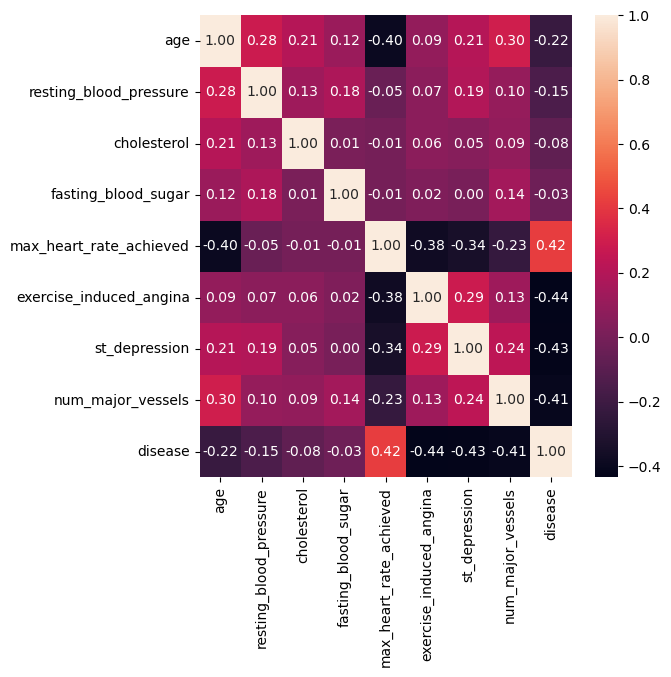

In [18]:
plt.figure(figsize = (6,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

Even though we don't have any strong correlation between target(disease) and the other columns, we can say that, "max_heart_rate_achieved" is positively, "exercise_induced_angina", "st_depression" and "num_major_vessels" columns are negatively corralated with the "disease" column.

**Visualize all Categorical Features**

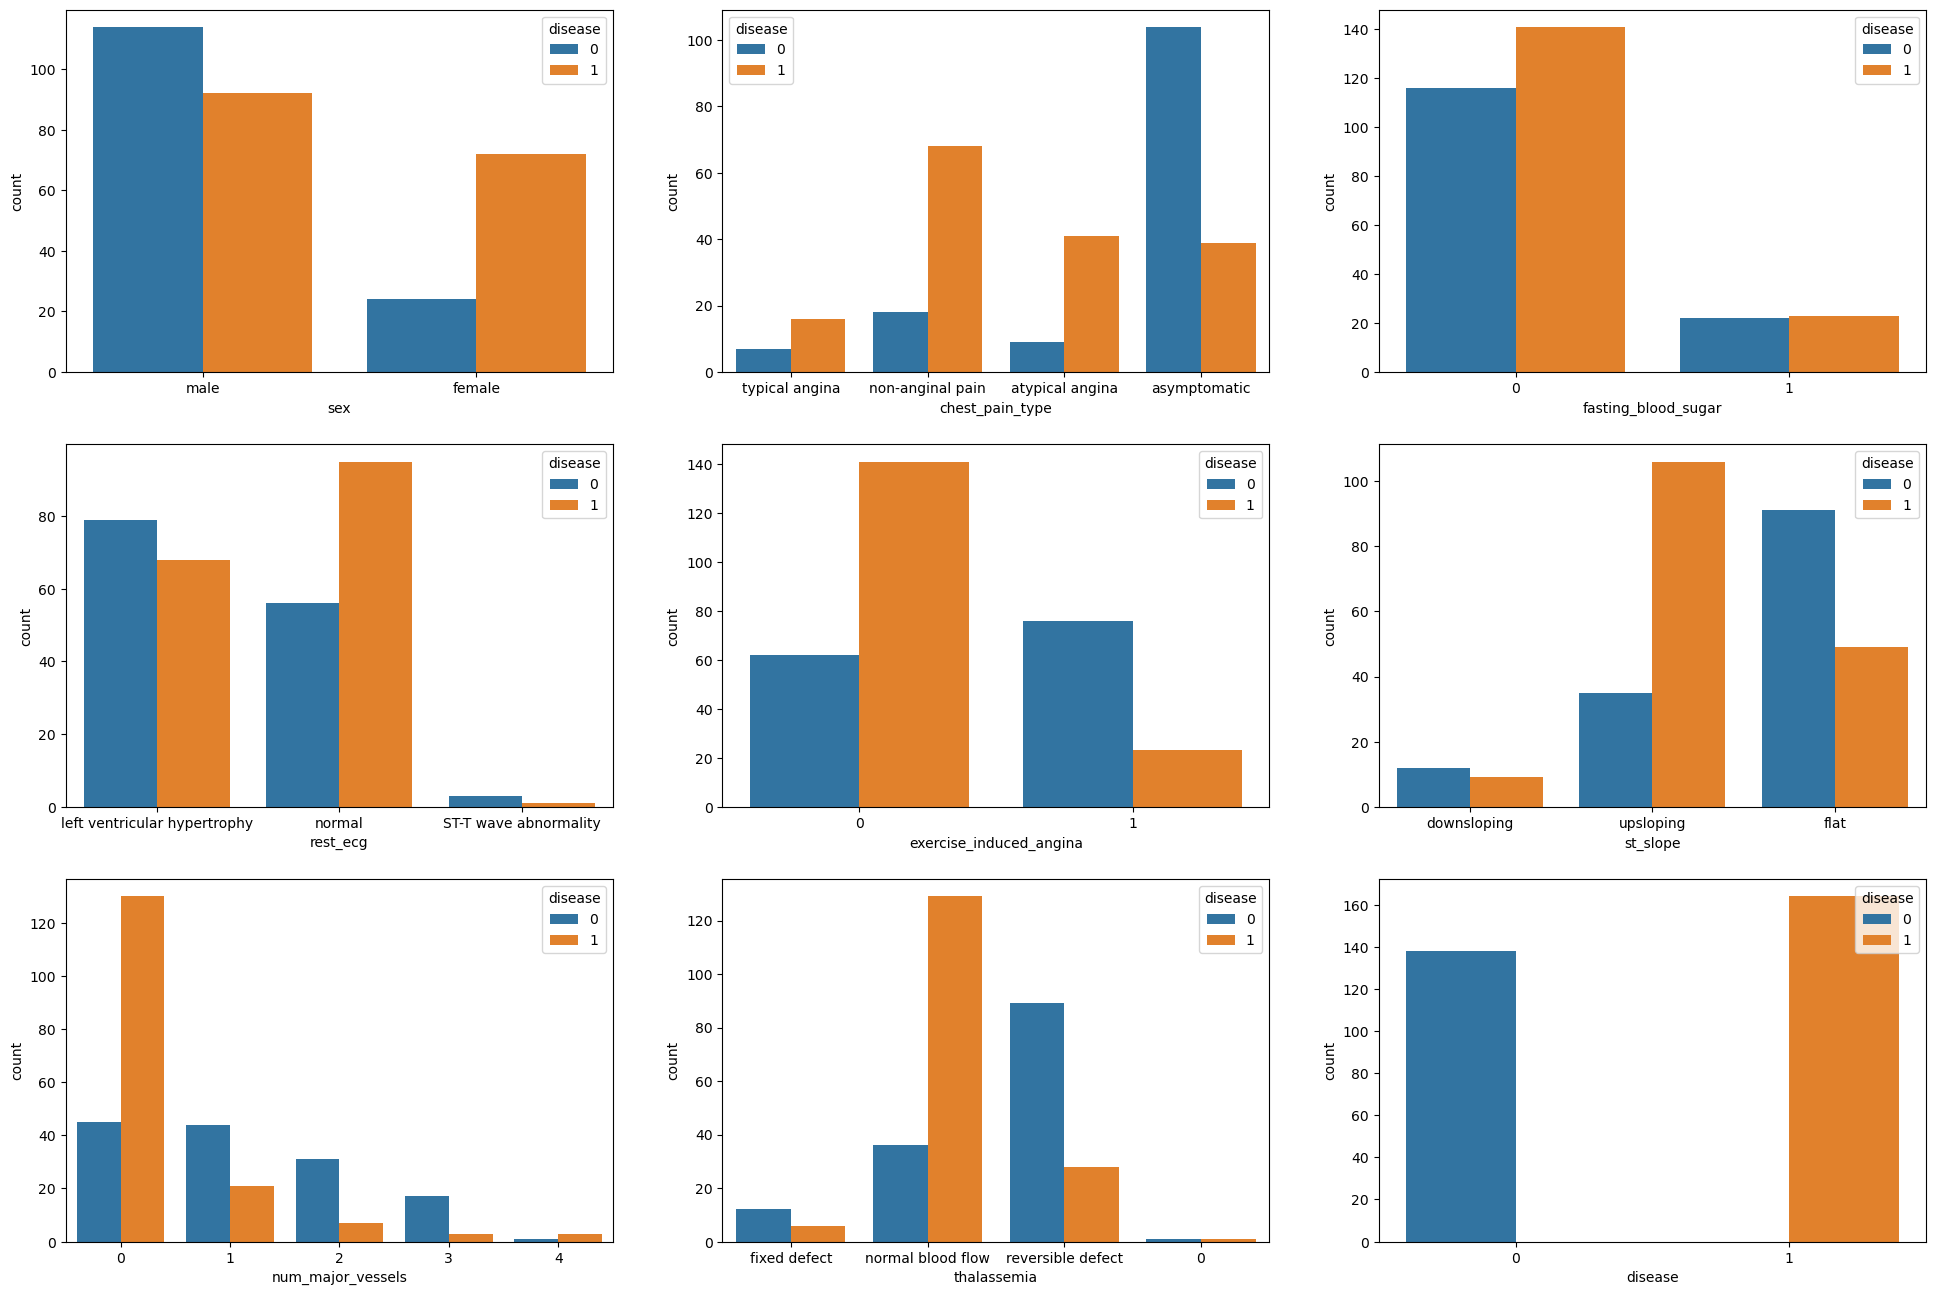

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24,16))

for idx, feature in enumerate(categorical_columns):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(x=feature, hue='disease', data=df, ax=ax)

**1) Sex**

* Number of Women suffering from Heart Disease are more than men but men population is more than women.

**2) Chest Pain Type**
* Populations with "non-anginal pain" and "atypical angina" are more likely to have the disease than others.

**3) Fasting Blood Sugar**
* People having fbs < 120 have more chance of having Heart Disease than people havnig fbs >120

**4) Resting Electrocardiographic Results**

An electrocardiogram (ECG) is a test which measures the electrical activity of your heart to show whether or not it is working normally. An ECG records the heart's rhythm and activity on a moving strip of paper or a line on a screen.

With the above chart as a reference, we can if resting electrocardiographic is normal then person have more chances of suffering from heart disease.

**5) Exercise Induced Angina**
* People with value 0 (No exercice induced angina) have heart disease more than people with value 1 (Yes exercice induced angina)

**6) The  Slope of the peak exercise ST segment**

slope: the slope of the peak exercise ST segment

People having up sloping are more prone to Heart Disease than flat and downsloping.

**7) Number of Major Vessels**
* We can see a large proportion of patients having a value of type 0 and type 4 had Heart Disease.

**8) Thalassemia**
*  People with thalassemia value equal to normal are more likely to have heart disease.

**9) Disease**

In [20]:
df.disease.value_counts()

1    164
0    138
Name: disease, dtype: int64

* So, the unique values are 1 and 0. (1 stands for presence of heart disease and 0 for absence of hear disease).
* We have 163 person with heart disease and 137 person without heart disease.
* From the above results, we can say that there is no imbalanced data. So we don't need to do synthetic data derivations. Otherwise, the accuracy metric (performance measurement metric) would not be meaningful.

**Distribution of Numerical features**

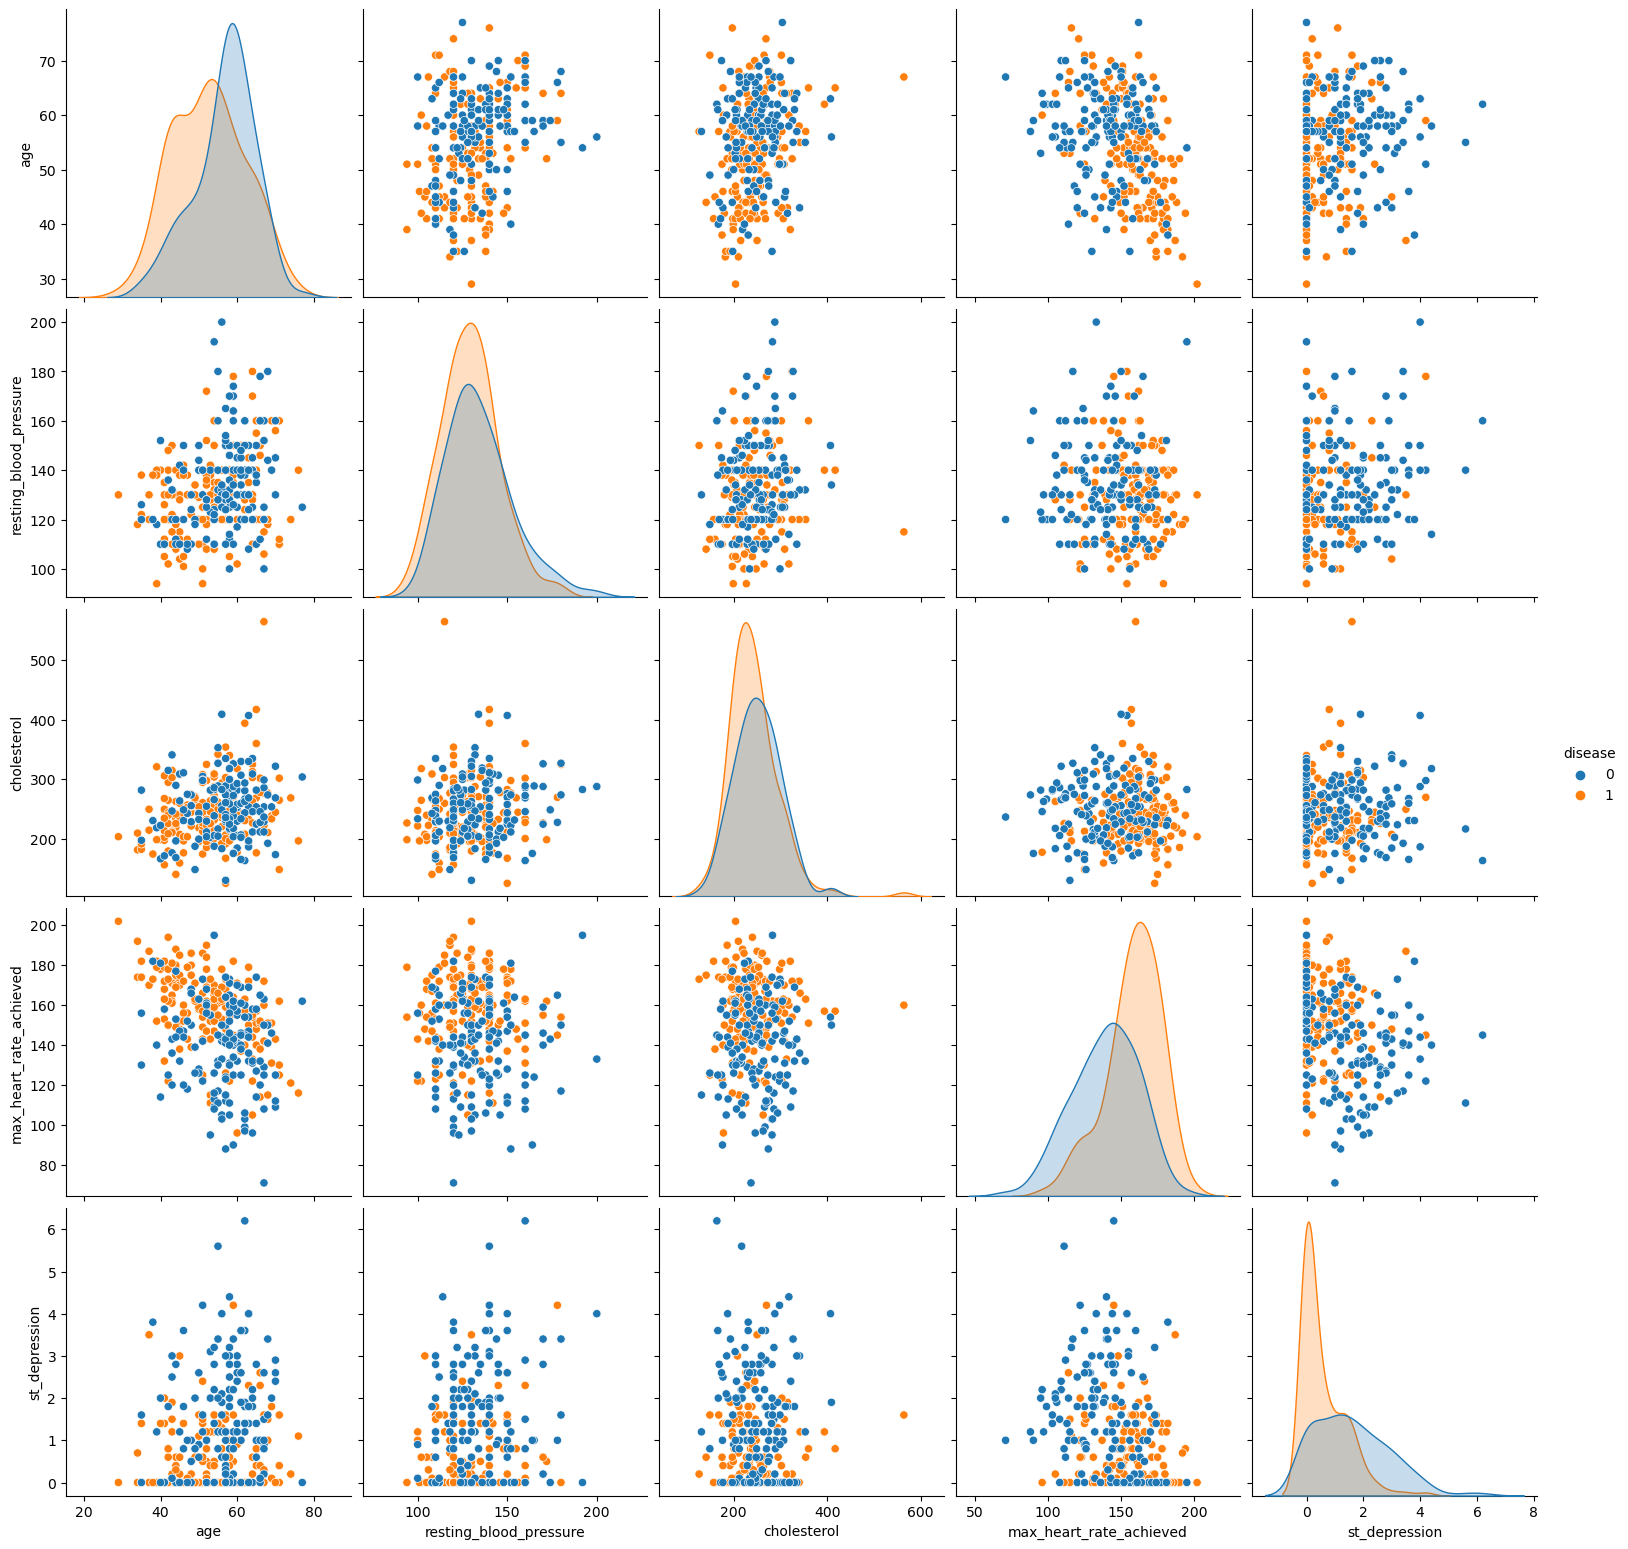

In [21]:
sns.pairplot(df, height=3.15, hue='disease', vars= continuous_columns)

plt.show()

* It seems that the probability of heart disease does not increase at the same rate as age increases.
* When the resting blood pressure value is between 100-150, the probability of heart disease increases.
* The higher the maximum heart rate, the higher the probability of disease.
* Cholesterol is in the range of 150-400, most heart disease is seen.
* Based on the graphs above, a low "st depression" increases the likelihood of heart disease.

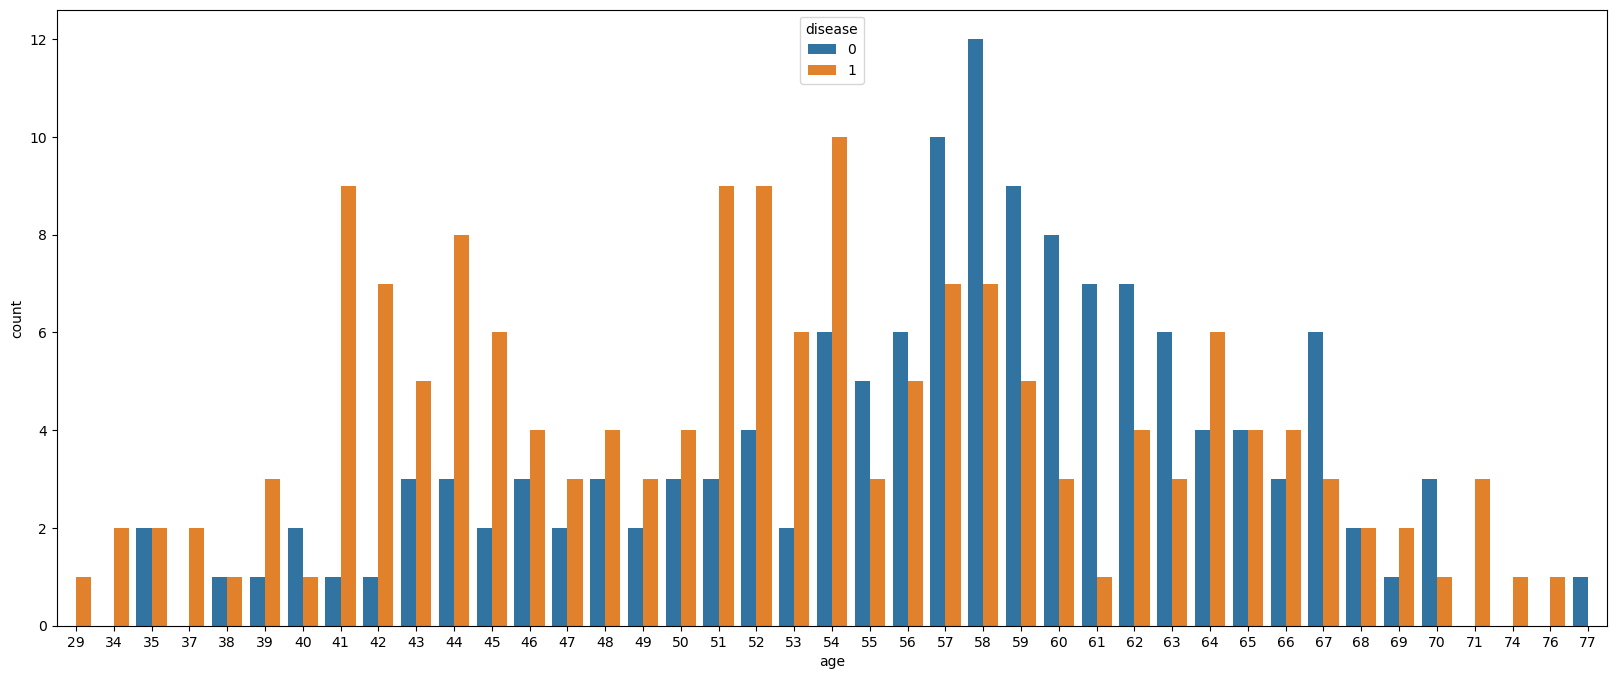

In [22]:
plt.figure(figsize=(20, 8))
sns.countplot(x = df.age, hue = df.disease);

* We see that people with heart disease in the 41-55 age range are much higher than the number of healthy people. This may be related to the fact that working people have more stress.

**Encoding Categorical Variables**

In [23]:
df = pd.get_dummies(df, drop_first=True)

df.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,disease,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal blood flow,thalassemia_reversible defect
0,63,145,233,1,150,0,2.3,0,1,1,0,0,1,1,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,0,1,1,0,1,0,0,1,0,0,0,1,0
2,41,130,204,0,172,0,1.4,0,1,0,1,0,0,1,0,0,1,0,1,0
3,56,120,236,0,178,0,0.8,0,1,1,1,0,0,0,1,0,1,0,1,0
4,57,120,354,0,163,1,0.6,0,1,0,0,0,0,0,1,0,1,0,1,0


**Splitting the Data**

In [24]:
X = df.drop(['disease'],axis=1)
y = df['disease']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [26]:
# checking distribution of traget variable in train test split

print('Distribution of traget variable in training set')
print(y_train.value_counts())

print('Distribution of traget variable in test set')
print(y_test.value_counts())

Distribution of traget variable in training set
1    131
0    110
Name: disease, dtype: int64
Distribution of traget variable in test set
1    33
0    28
Name: disease, dtype: int64


In [27]:
print('------------Training Set------------------')
print()
print('Shape of X_train' ,X_train.shape)
print('Shape of y_train' ,y_train.shape)
print()
print('------------Test Set------------------')
print()
print('Shape of X_test' ,X_test.shape)
print('Shape of y_test' ,y_test.shape)


------------Training Set------------------

Shape of X_train (241, 19)
Shape of y_train (241,)

------------Test Set------------------

Shape of X_test (61, 19)
Shape of y_test (61,)


**Feature Normalization**

In this step we will normalize all the numeric feature in the range of 0 to 1.

In [28]:
scaler = MinMaxScaler()

X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_train.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal blood flow,thalassemia_reversible defect
59,0.583333,0.320755,0.625442,0,0.622807,0,0.000000,1,0,0,0,0,1,0,0,1,0,1,0
247,0.770833,0.622642,0.424028,0,0.280702,1,0.000000,3,1,1,0,0,0,1,1,0,1,0,0
289,0.541667,0.320755,0.279152,0,0.368421,1,0.322581,1,0,0,0,0,0,0,1,0,0,0,1
288,0.583333,0.150943,0.738516,0,0.482456,1,0.483871,1,1,0,0,0,0,1,1,0,0,0,1
64,0.604167,0.433962,0.300353,1,0.675439,0,0.000000,0,1,0,1,0,1,0,0,1,0,1,0


**Logistic Regression**

In [29]:
log=LogisticRegression().fit(X_train,y_train)


In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
#log params  (RandomSearch vs Gridsearchcv)
log_params={
    "C":[1,2,3,4,5,0,5,2,5,6,7,8],
    "penalty":["l1","l2","elasticnet"],
    "solver":["lbfgs","liblinear"]
}

In [32]:
#Randomsearch
log_rs_cv=RandomizedSearchCV(log,log_params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [33]:
log_rs_cv.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 6}

In [34]:
log_tun_rs=LogisticRegression(solver="lbfgs",penalty="l2",C=1).fit(X_train,y_train)

In [35]:
y_pred=log_tun_rs.predict(X_test)
accuracy_score(y_test,y_pred)

0.45901639344262296

**Random Forest**

In [36]:
rf=RandomForestClassifier().fit(X_train,y_train)

In [37]:
#for randomized
rf_params1={
    "n_estimators":np.arange(50,1000,50),
    "max_depth":np.arange(2,11),
    "max_features":np.arange(1,15),
    "min_samples_split":[2,3,4,5,6,7,8,9,10],
    "criterion":["gini","entropy"]
}

In [39]:
rf_cv_rs=RandomizedSearchCV(rf,rf_params1,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [40]:
rf_cv_rs.best_params_


{'n_estimators': 50,
 'min_samples_split': 6,
 'max_features': 1,
 'max_depth': 4,
 'criterion': 'gini'}

In [41]:
rf_rs_tun=RandomForestClassifier(n_estimators=150,min_samples_split=2,
                                max_features=3,max_depth=6,
                                 criterion="gini").fit(X_train,y_train)

In [42]:
y_pred=rf_rs_tun.predict(X_test)
accuracy_score(y_test,y_pred)

0.7049180327868853

**XGBOOST**

In [43]:
xgb_model = XGBClassifier().fit(X_train,y_train)

In [44]:
xgb_params = {
    "n_estimators":[100,200,500,1000],
    "subsample":[0.6,0.5,0.8,1],
    "max_depth":[3,5,7],
    "learning_rate":[0.1,0.001,0.01]
}

In [45]:
xgb_cv = GridSearchCV(xgb_model,xgb_params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


In [46]:
xgb_best_params = xgb_cv.best_params_
xgb_best_params

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [47]:
xgb_tun = XGBClassifier(learning_rate=0.01,
                        max_depth=3,
                        n_estimators=200,
                        subsample=0.5).fit(X_train,y_train)

In [48]:
y_pred = xgb_tun.predict(X_test)
accuracy_score(y_test,y_pred)

0.7704918032786885

We got the best accuracy with XGBoost.

**Variable Importance Level**

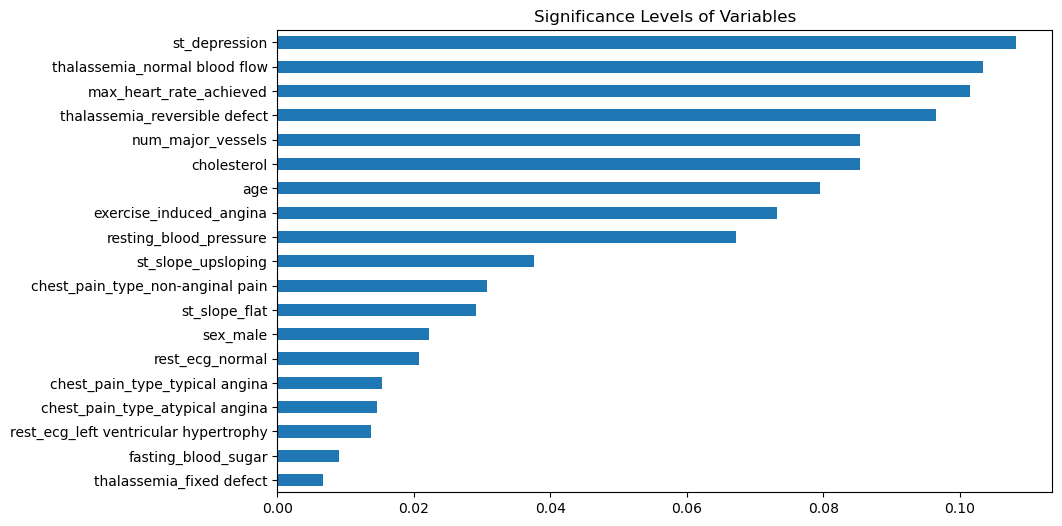

In [49]:
importance_degrees = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

importance_degrees_sorted = importance_degrees.sort_values()
plt.figure(figsize=(10,6))
importance_degrees_sorted.plot(kind='barh')
plt.title('Significance Levels of Variables')
plt.show()

**BentoML**

In [50]:
!bentoml --version

bentoml, version 1.0.7


In [51]:
# Contruct DMatrix for train and test sets

dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(data=X_test.values, label=y_test)

In [52]:
bst = xgb.train(xgb_best_params, dtrain)

[02:59:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [53]:
# Make predictions and calculate auc

y_pred = bst.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8766233766233766

**Save the Model**

In [54]:
bento_model = bentoml.xgboost.save_model("heart_disease", bst)

In [55]:
import bentoml
from bentoml.io import NumpyNdarray
import numpy as np


model_ref = bentoml.xgboost.get("heart_disease:latest")

model_runner = bentoml.xgboost.get("heart_disease:latest").to_runner()

svc = bentoml.Service("heart_disease", runners=[model_runner])

@svc.api(input=NumpyNdarray(), output=NumpyNdarray()) 
def classify(input: np.ndarray):
    prediction= model_runner.predict.run(input)
    return prediction 

# bentoml serve service_midterm.py:svc --reload

**service_midterm.py file that runs the service**

In [ ]:
import bentoml
from bentoml.io import NumpyNdarray
import numpy as np


model_ref = bentoml.xgboost.get("heart_disease:latest")

model_runner = bentoml.xgboost.get("heart_disease:latest").to_runner()

svc = bentoml.Service("heart_disease", runners=[model_runner])

@svc.api(input=NumpyNdarray(), output=NumpyNdarray()) 
def classify(input: np.ndarray):
    prediction= model_runner.predict.run(input)
    return prediction
    
# bentoml serve service_midterm.py:svc --reload

**We need .yaml file to build the bento**

service: "service_midterm.py:svc"
labels:
  owner: uguror
  projects: midterm
include:
- "*.py"
python:
  packages:
    - xgboost
    - sklearn

**Build bento from the .yaml file**

- build bento: bentoml build

- docker container: bentoml containerize  [bento name:code given after 'bentoml build']

- make sure docker service is running if setting up locally

- run docker container: docker run -it --rm -p 3000:3000 heart_disease:rz32ygs5gwypotgm serve --production

#### **Cloud deployment on AWS**


1.Login to AWS Console

2.Go to Elastic Container Registry. Select Create Registry.

3.In registry select "View push commands"

- On local Windows PC use GitBash and follow macOS/Linux commands.NOTE: Must have AWS CLI installed.

- AWS console, login via the prompts.

- (Get-ECRLoginCommand).Password | docker login --username AWS --password-stdin aws_account_id.dkr.ecr.region.amazonaws.com

- Skip this command, docker build done though bentoml -> docker build -t heart-disease .

- docker tag heart-disease:latest [censored].dkr.ecr.us-east-1.amazonaws.com/heart-disease:latest

- docker push [censored].dkr.ecr.us-east-1.amazonaws.com/heart-disease:latest

4.Move to Elastic Container Service, then Select Create new Task Definition.

- Follow prompts, be sure to sleect image uploaded to the registry.

- Then select Create

5.Select Clusters on the left pane, then Select create cluster.

- Follow the prompts to create cluster

- Select the cluster

- Select Tasks and then Run new Task

- Follow prompts and select the created task.

    - select Run Task

6.Select ECS and add container

- Enter the Container name (heart-disease-container) and Image URI

- Memory Limits(MiB), set to Soft limit and 256

- Port mappings, Container port 3000 and Protocol tcp

- Click to end at the end

7.Cluster

- Go Cluster again and clik to Tasks

- Run a new task

- Launch type, FARGATE

- Operating system family, Linux

- Cluster VPC*, select the defaul value

- Subnets, us-east-1a

- Security groups, Type = Custom TCP, Port range = 3000

- Go back to Cluster and wait for the Last status value until it gets from Provisioning to Running

- Select the task from the column

- From the Network you can copy the Public IP

- Now you can reach the Bentoml Api by using this Public IP and addin to the end port number (3000)

- For instance: 54.161.38.215:3000

**Production App Access**

To access production site go here: http://54.161.38.215:3000/

- Select Try it out in the POST section. Use template below. Change the variable

- In Request body enter patient information based on template
    - Given samles must be in NumpyNdarray format.
- Template: [[0.583333,0.320755,0.625440,0,0.622800,0,0.322000,2,1,0,0,0,1,0,0,1,0,1,0]]

- Select Execute

- Scroll down to Server response and see response in Response body.

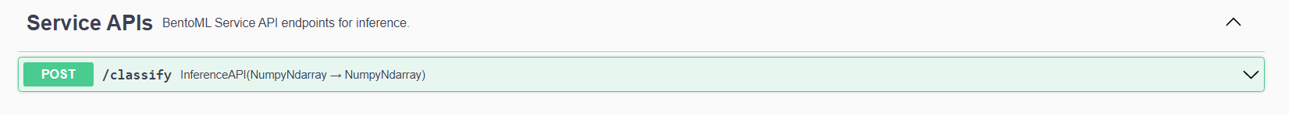

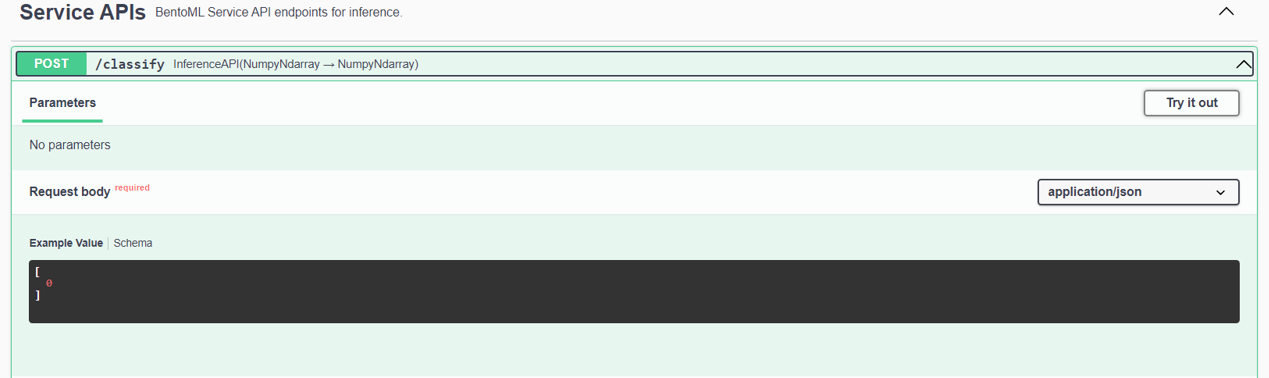

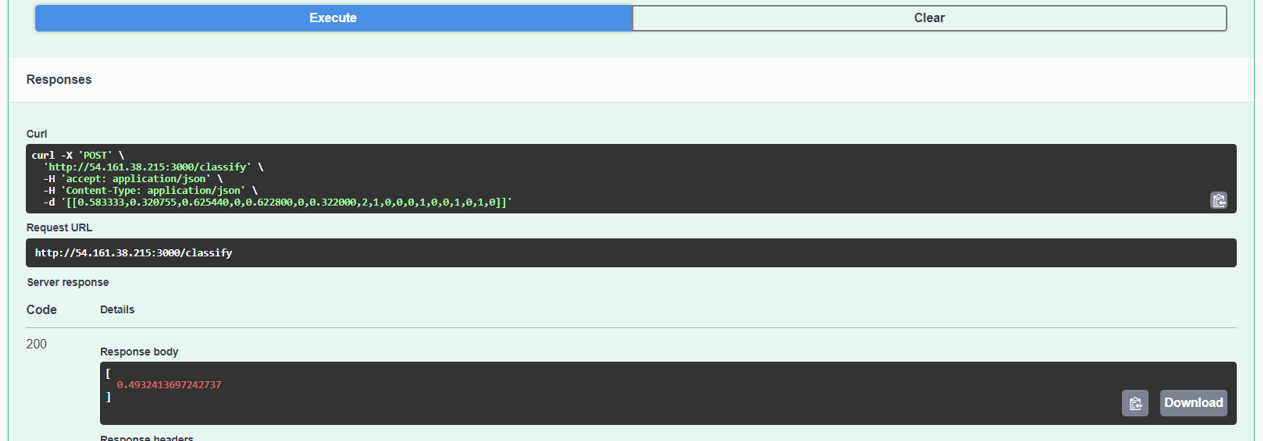

JSON format corresponding to the template


{"age": 0.583333,
"resting_blood_pressure": 0.320755,
"cholesterol": 0.625440,
"fasting_blood_sugar": 0,
"max_heart_rate_achieved": 0.622800,
"exercise_induced_angina": 0,
"st_depression": 0.322000,
"num_major_vessels": 2,
"sex_male": 1,
"chest_pain_type_atypical angina": 0,
"chest_pain_type_non-anginal pain": 0,
"chest_pain_type_typical angina": 0,
"rest_ecg_left ventricular hypertrophy": 1,
"rest_ecg_normal": 0,
"st_slope_flat": 0,
"st_slope_upsloping": 1,
"thalassemia_fixed defect": 0,
"thalassemia_normal blood flow": 1,
"thalassemia_reversible defect": 0
}



As a response you will get a number between 0-1

That is the possibility of the disease. The closer it is to 1, the higher the probability of getting the disease.